In [79]:
# === Five-Strategy Comparison Notebook ===
# VolGAN is the Main Strategy - Compare Against Naive, Delta, Delta-Vega, Delta-Gamma

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

In [80]:
# === SECTION 1: Load All Results ===

# Load CSV files
results_naive = pd.read_csv('results_naive.csv')
results_delta = pd.read_csv('results_delta.csv')
results_deltavega = pd.read_csv('results_deltavega.csv')
results_deltagamma = pd.read_csv('results_gamma.csv')
results_volgan = pd.read_csv('results_volgan_final.csv')

# Convert ALL date columns to datetime with error handling
for df in [results_naive, results_delta, results_deltavega, results_deltagamma, results_volgan]:
    df['start'] = pd.to_datetime(df['start'], errors='coerce')
    df['end'] = pd.to_datetime(df['end'], errors='coerce')
    
    # Drop rows with invalid dates
    df.dropna(subset=['start', 'end'], inplace=True)

# Add strategy labels
results_naive['strategy'] = 'Naive'
results_delta['strategy'] = 'Delta'
results_deltavega['strategy'] = 'Delta-Vega'
results_deltagamma['strategy'] = 'Delta-Gamma'
results_volgan['strategy'] = 'VolGAN'

results_all = pd.concat([results_naive, results_delta, results_deltavega, 
                         results_deltagamma, results_volgan], 
                        ignore_index=True)

# Check for data issues
print("\n" + "="*80)
print("Data Loading Diagnostics")
print("="*80)
for name, df in [('Naive', results_naive), ('Delta', results_delta), 
                  ('Delta-Vega', results_deltavega), ('Delta-Gamma', results_deltagamma), 
                  ('VolGAN', results_volgan)]:
    print(f"{name:15s}: {len(df)} rows, dates {df['start'].min()} to {df['end'].max()}")
    print(f"  Unique m0 values: {sorted(df['m0'].unique())}")
print("="*80)

print("="*80)
print("Data Loaded Successfully - VolGAN as Main Strategy")
print("="*80)
print(f"Total windows: {len(results_all)}")
print(f"\nBreakdown by strategy:")
print(results_all['strategy'].value_counts().sort_index())
print("="*80)


Data Loading Diagnostics
Naive          : 60 rows, dates 2021-01-04 00:00:00 to 2023-06-06 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
Delta          : 60 rows, dates 2021-01-04 00:00:00 to 2023-06-06 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
Delta-Vega     : 120 rows, dates 2021-01-04 00:00:00 to 2023-06-06 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
Delta-Gamma    : 60 rows, dates 2021-01-04 00:00:00 to 2023-06-06 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
VolGAN         : 60 rows, dates 2021-01-04 00:00:00 to 2023-06-06 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
Data Loaded Successfully - VolGAN as Main Strategy
Total windows: 360

Breakdown by strategy:
strategy
Delta           60
Delta-Gamma     60
Delta-V

/var/folders/lf/j1p7b9893pb19dwl2jcxhw900000gn/T/ipykernel_34288/112788805.py:15: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/user/Desktop/y3s1/qf209/VolGAN-replica/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


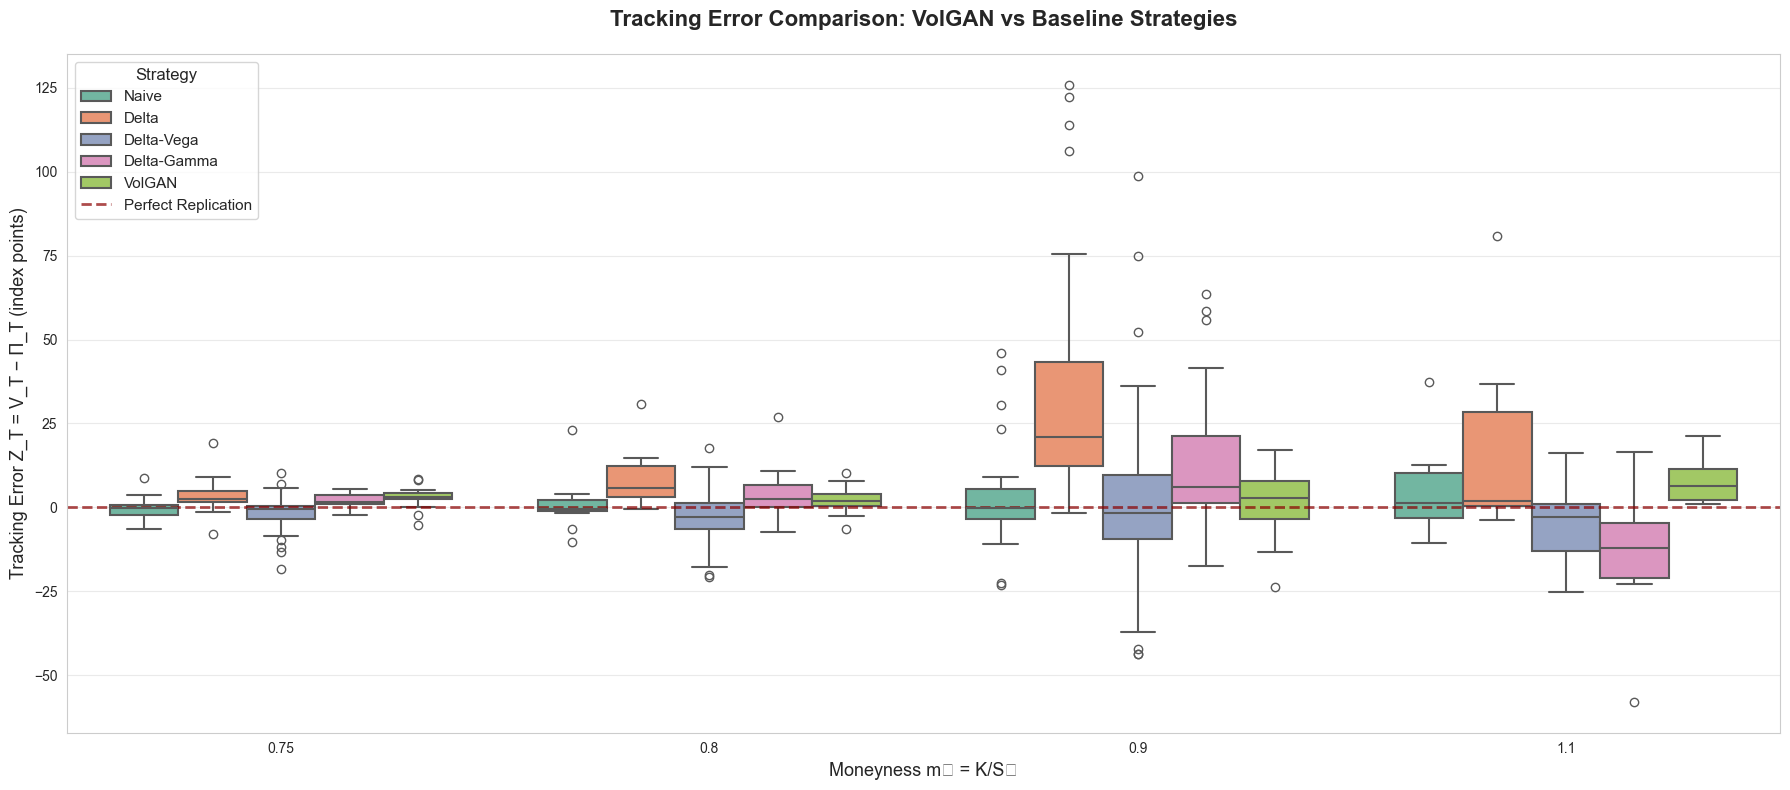

In [81]:
# === SECTION 2: Box Plot Comparison by Moneyness ===

plt.figure(figsize=(18, 8))
sns.boxplot(x='m0', y='tracking_error', hue='strategy', data=results_all, 
            palette='Set2', linewidth=1.5)

plt.title('Tracking Error Comparison: VolGAN vs Baseline Strategies', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Moneyness m₀ = K/S₀', fontsize=13)
plt.ylabel('Tracking Error Z_T = V_T − Π_T (index points)', fontsize=13)
plt.axhline(y=0, color='darkred', linestyle='--', linewidth=2, alpha=0.7, 
            label='Perfect Replication')
plt.legend(title='Strategy', fontsize=11, title_fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

In [82]:
# === SECTION 3: Summary Statistics Table ===

summary_all = results_all.groupby(['strategy', 'm0'])['tracking_error'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std Dev', 'std'),
    ('VaR 5%', lambda x: x.quantile(0.05)),
    ('VaR 1%', lambda x: x.quantile(0.01))
]).round(3)

print("\n" + "="*100)
print("Tracking Error Summary Statistics by Strategy and Moneyness")
print("="*100)
print(summary_all)
print("="*100)


Tracking Error Summary Statistics by Strategy and Moneyness
                  Count    Mean  Median  Std Dev  VaR 5%  VaR 1%
strategy    m0                                                  
Delta       0.75     13   3.639   2.441    6.195  -3.988  -7.203
            0.80     15   8.062   5.650    8.068   0.273  -0.229
            0.90     26  36.179  20.837   38.928   1.004  -1.450
            1.10      6  19.715   1.988   33.464  -2.770  -3.634
Delta-Gamma 0.75     13   1.927   1.586    2.404  -2.232  -2.268
            0.80     15   4.057   2.392    7.889  -3.676  -6.562
            0.90     26  13.120   6.217   22.521 -17.208 -17.371
            1.10      6 -15.245 -11.963   24.834 -49.172 -56.178
Delta-Vega  0.75     26  -1.955  -0.588    6.274 -12.811 -17.021
            0.80     30  -2.996  -2.894    8.402 -19.095 -20.590
            0.90     52   0.832  -1.689   25.506 -39.420 -43.773
            1.10     12  -3.702  -2.966   11.939 -19.369 -24.048
Naive       0.75     13  -0.2

In [83]:
# === SECTION 4: Aggregate Performance Metrics ===

# Overall performance by strategy
perf_summary = results_all.groupby('strategy')['tracking_error'].agg([
    ('Mean |Error|', lambda x: x.abs().mean()),
    ('Median |Error|', lambda x: x.abs().median()),
    ('Std Dev', 'std'),
    ('RMSE', lambda x: np.sqrt((x**2).mean())),
    ('MAE', lambda x: x.abs().mean()),
    ('VaR 5%', lambda x: x.quantile(0.05)),
    ('CVaR 5%', lambda x: x[x <= x.quantile(0.05)].mean()),
    ('Min Error', lambda x: x.min()),
    ('Max Error', lambda x: x.max()),
]).round(3)

perf_summary = perf_summary.sort_values('Mean |Error|')

print("\n" + "="*100)
print("Overall Strategy Performance (Lower is Better)")
print("="*100)
print(perf_summary)
print("="*100)


Overall Strategy Performance (Lower is Better)
             Mean |Error|  Median |Error|  Std Dev    RMSE     MAE  VaR 5%  \
strategy                                                                     
VolGAN              5.921           3.804    7.354   7.799   5.921  -9.366   
Naive               6.954           3.076   12.403  12.499   6.954 -10.569   
Delta-Vega         10.733           5.932   17.912  17.876  10.733 -25.428   
Delta-Gamma        11.797           5.354   18.863  19.523  11.797 -17.227   
Delta              20.984           8.595   31.155  37.051  20.984  -1.328   

             CVaR 5%  Min Error  Max Error  
strategy                                    
VolGAN       -16.480    -23.604     21.387  
Naive        -18.855    -23.064     45.965  
Delta-Vega   -37.830    -43.784     98.582  
Delta-Gamma  -32.751    -57.929     63.553  
Delta         -4.519     -8.007    125.886  


In [84]:
# === SECTION 5: VolGAN Performance Ranking ===

print("\n" + "="*80)
print("VolGAN Performance Ranking")
print("="*80)

volgan_perf = perf_summary.loc['VolGAN']
print(f"\nVolGAN Metrics:")
print(volgan_perf)

for idx, (strategy, metrics) in enumerate(perf_summary.iterrows(), 1):
    if strategy == 'VolGAN':
        print(f"\n🎯 VolGAN Rank: #{idx} out of 5 strategies")
        print(f"   Position: {'BEST' if idx == 1 else 'COMPETITIVE' if idx <= 3 else 'NEEDS IMPROVEMENT'}")
        break

print("="*80)


VolGAN Performance Ranking

VolGAN Metrics:
Mean |Error|       5.921
Median |Error|     3.804
Std Dev            7.354
RMSE               7.799
MAE                5.921
VaR 5%            -9.366
CVaR 5%          -16.480
Min Error        -23.604
Max Error         21.387
Name: VolGAN, dtype: float64

🎯 VolGAN Rank: #1 out of 5 strategies
   Position: BEST


/var/folders/lf/j1p7b9893pb19dwl2jcxhw900000gn/T/ipykernel_34288/1647785051.py:14: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/user/Desktop/y3s1/qf209/VolGAN-replica/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


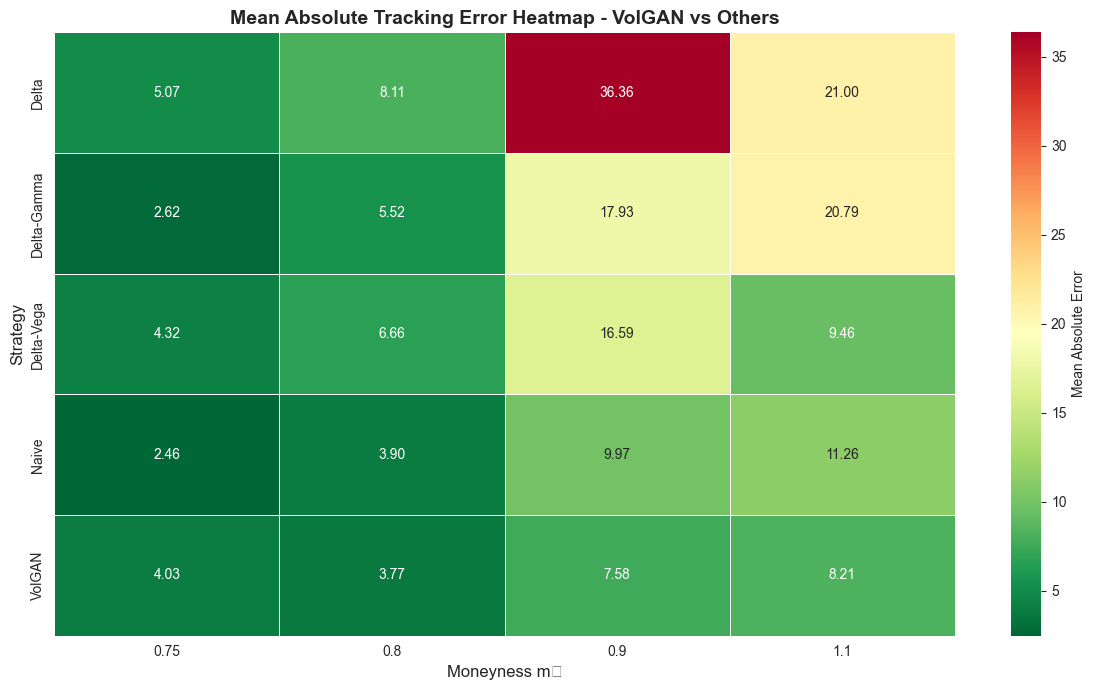

In [85]:
# === SECTION 6: Heatmap of Mean Absolute Errors ===

mae_pivot = results_all.groupby(['strategy', 'm0'])['tracking_error'].apply(
    lambda x: x.abs().mean()
).unstack()

plt.figure(figsize=(12, 7))
sns.heatmap(mae_pivot, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            linewidths=0.5, cbar_kws={'label': 'Mean Absolute Error'})
plt.title('Mean Absolute Tracking Error Heatmap - VolGAN vs Others', 
          fontsize=14, fontweight='bold')
plt.xlabel('Moneyness m₀', fontsize=12)
plt.ylabel('Strategy', fontsize=12)
plt.tight_layout()
plt.show()

/var/folders/lf/j1p7b9893pb19dwl2jcxhw900000gn/T/ipykernel_34288/2701008327.py:14: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/user/Desktop/y3s1/qf209/VolGAN-replica/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


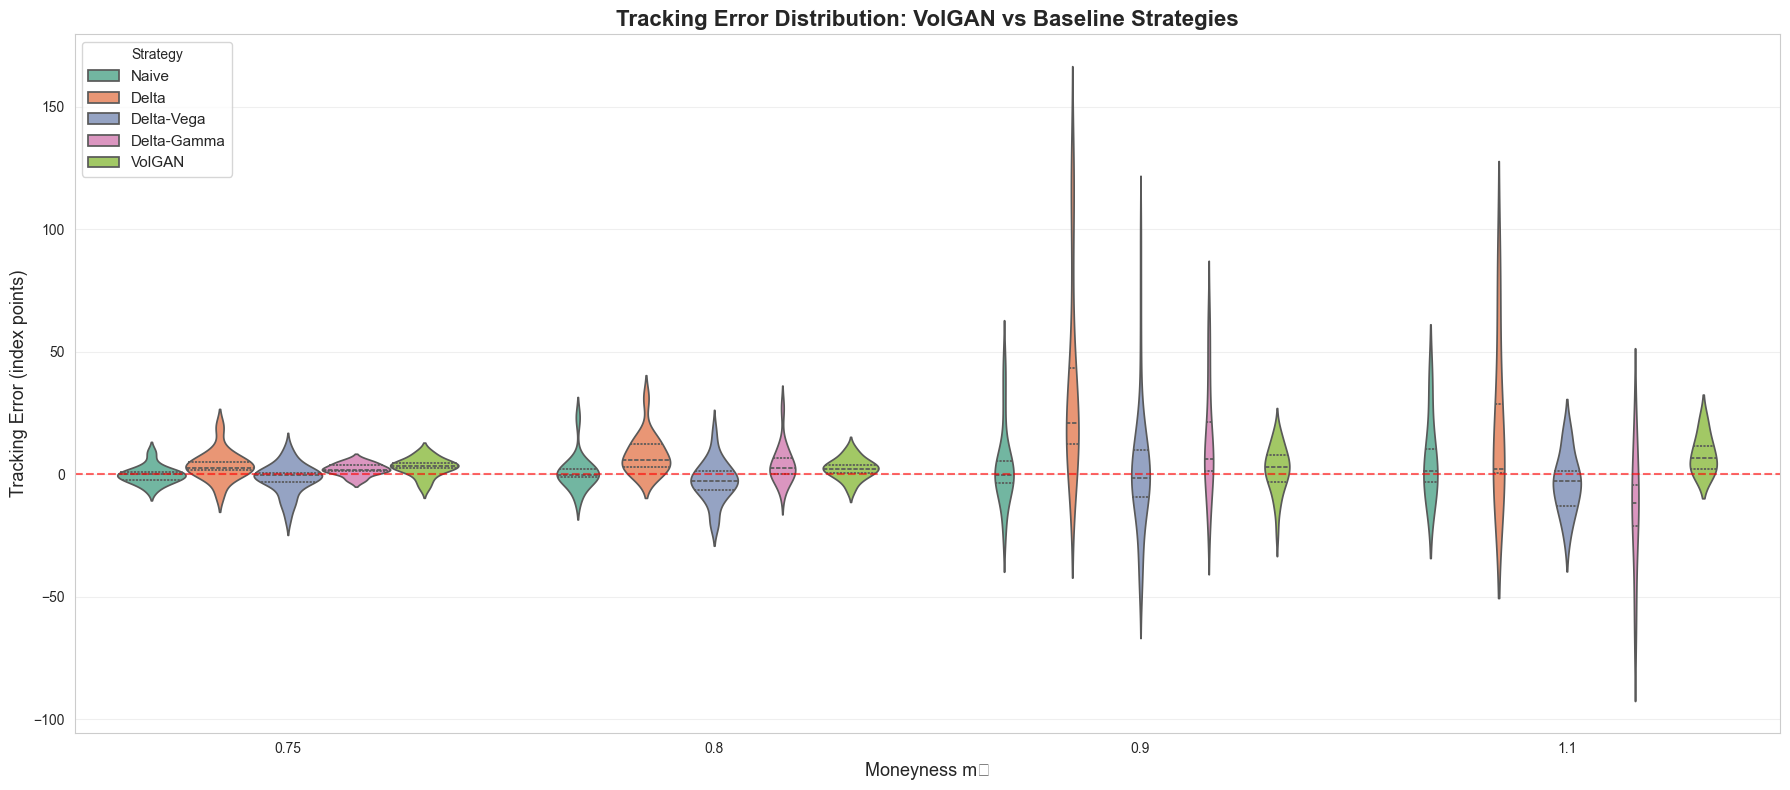

In [86]:
# === SECTION 7: Violin Plot (Distribution Comparison) ===

plt.figure(figsize=(18, 8))
sns.violinplot(x='m0', y='tracking_error', hue='strategy', data=results_all,
               palette='Set2', split=False, inner='quartile')

plt.title('Tracking Error Distribution: VolGAN vs Baseline Strategies', 
          fontsize=16, fontweight='bold')
plt.xlabel('Moneyness m₀', fontsize=13)
plt.ylabel('Tracking Error (index points)', fontsize=13)
plt.axhline(0, color='red', linestyle='--', alpha=0.6)
plt.legend(title='Strategy', fontsize=11, loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

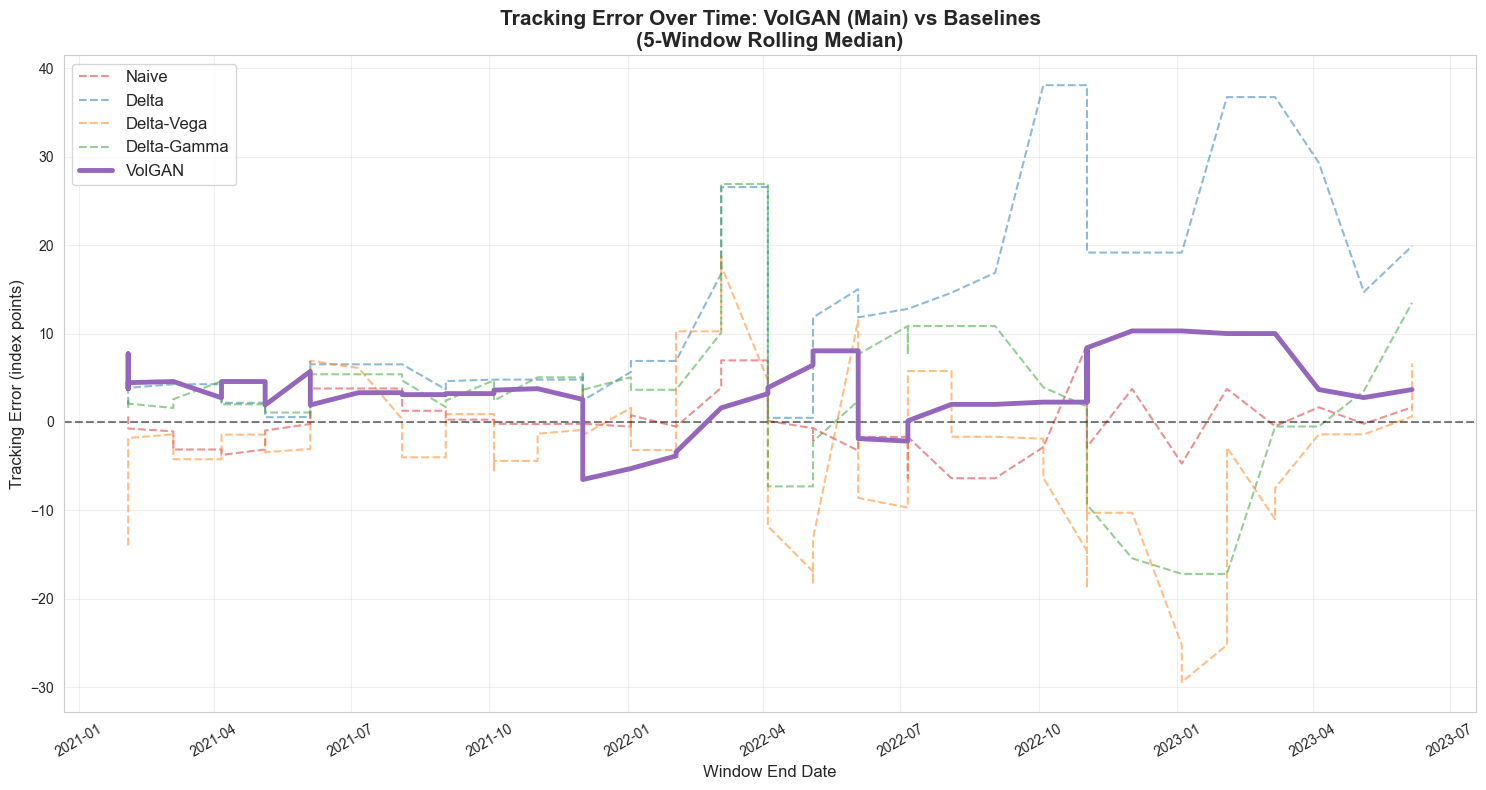

In [87]:
# === SECTION 8: Time Series Comparison (VolGAN Highlighted) ===

time_comparison = results_all.sort_values('end')

plt.figure(figsize=(15, 8))
strategy_colors = {
    'Naive': '#d62728',
    'Delta': '#1f77b4',
    'Delta-Vega': '#ff7f0e',
    'Delta-Gamma': '#2ca02c',
    'VolGAN': '#9467bd'
}

# Plot baselines first (lighter)
for strategy in ['Naive', 'Delta', 'Delta-Vega', 'Delta-Gamma']:
    subset = time_comparison[time_comparison['strategy'] == strategy]
    subset_sorted = subset.sort_values('end')
    plt.plot(subset_sorted['end'], 
             subset_sorted['tracking_error'].rolling(5, min_periods=1).median(),
             label=strategy, linewidth=1.5, alpha=0.5, color=strategy_colors[strategy], linestyle='--')

# Plot VolGAN last (darker, thicker)
subset = time_comparison[time_comparison['strategy'] == 'VolGAN']
subset_sorted = subset.sort_values('end')
plt.plot(subset_sorted['end'], 
         subset_sorted['tracking_error'].rolling(5, min_periods=1).median(),
         label='VolGAN', linewidth=3.5, alpha=1.0, color=strategy_colors['VolGAN'], zorder=10)

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title('Tracking Error Over Time: VolGAN (Main) vs Baselines\n(5-Window Rolling Median)', 
          fontsize=15, fontweight='bold')
plt.xlabel('Window End Date', fontsize=12)
plt.ylabel('Tracking Error (index points)', fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

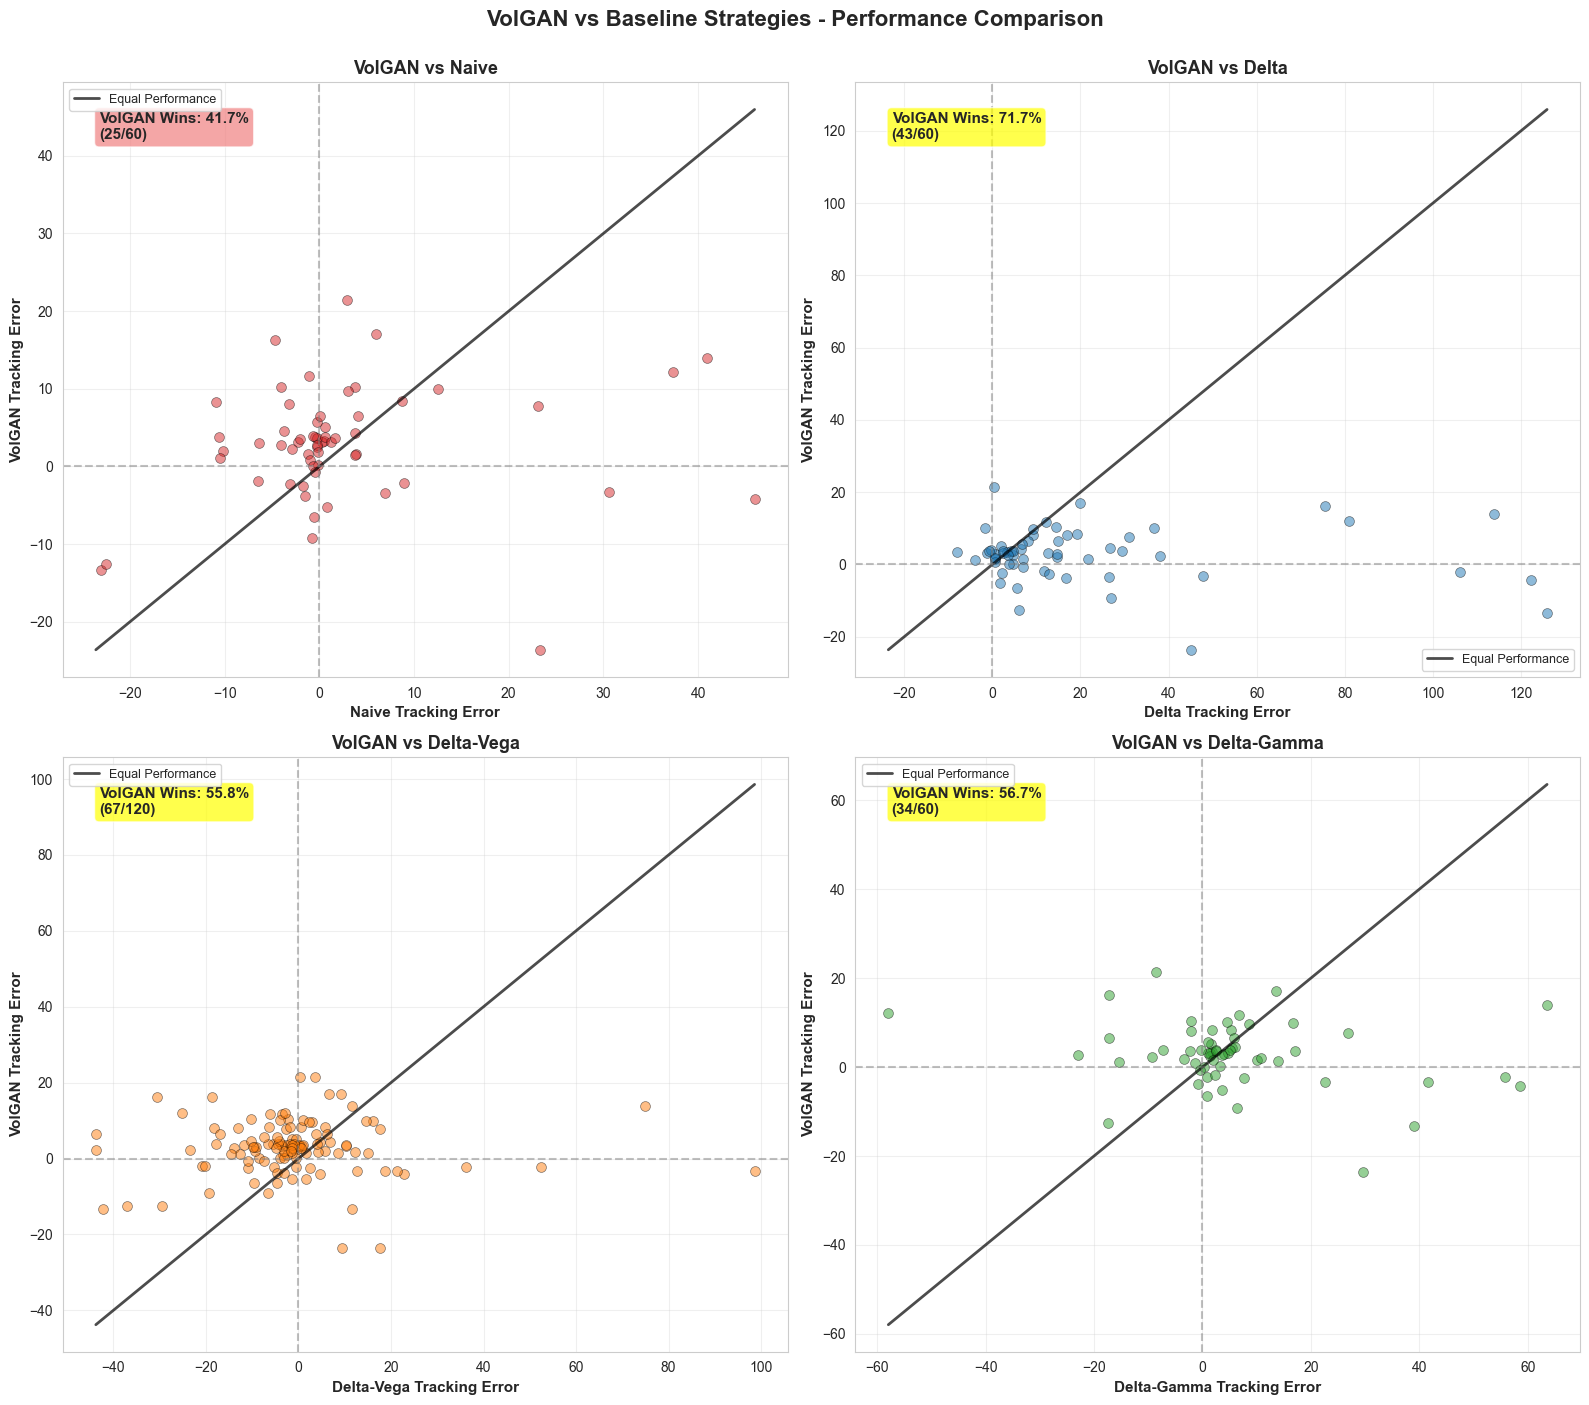

In [88]:
# === SECTION 9: Pairwise Scatter Plots (VolGAN vs Each Baseline) ===

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

strategies_to_compare = ['Naive', 'Delta', 'Delta-Vega', 'Delta-Gamma']
colors = {
    'Naive': '#d62728',
    'Delta': '#1f77b4',
    'Delta-Vega': '#ff7f0e',
    'Delta-Gamma': '#2ca02c',
}

for idx, other_strategy in enumerate(strategies_to_compare):
    ax = axes[idx]
    
    # Merge datasets
    other_df = results_all[results_all['strategy'] == other_strategy]
    volgan_df = results_all[results_all['strategy'] == 'VolGAN']
    
    merged = other_df.merge(
        volgan_df,
        on=['start', 'end', 'm0'],
        suffixes=(f'_{other_strategy}', '_VolGAN')
    )
    
    # Scatter plot
    ax.scatter(merged[f'tracking_error_{other_strategy}'], 
               merged['tracking_error_VolGAN'],
               alpha=0.5, s=50, color=colors[other_strategy], edgecolors='black', linewidth=0.5)
    
    # 45-degree line
    lims = [merged[[f'tracking_error_{other_strategy}', 'tracking_error_VolGAN']].min().min(),
            merged[[f'tracking_error_{other_strategy}', 'tracking_error_VolGAN']].max().max()]
    ax.plot(lims, lims, 'k-', linewidth=2, alpha=0.7, label='Equal Performance')
    
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    
    ax.set_xlabel(f'{other_strategy} Tracking Error', fontsize=11, fontweight='bold')
    ax.set_ylabel('VolGAN Tracking Error', fontsize=11, fontweight='bold')
    ax.set_title(f'VolGAN vs {other_strategy}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # Add win rate box
    volgan_wins = (merged['tracking_error_VolGAN'].abs() < 
                   merged[f'tracking_error_{other_strategy}'].abs()).sum()
    total = len(merged)
    win_pct = 100 * volgan_wins / total
    
    ax.text(0.05, 0.95, f'VolGAN Wins: {win_pct:.1f}%\n({volgan_wins}/{total})',
            transform=ax.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='yellow' if win_pct > 50 else 'lightcoral', alpha=0.7),
            fontweight='bold')

plt.suptitle('VolGAN vs Baseline Strategies - Performance Comparison', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [89]:
# === SECTION 10: VolGAN Win Rate Analysis (MAIN SECTION) ===

print("\n" + "="*80)
print("🎯 VolGAN WIN RATE ANALYSIS - MAIN RESULTS")
print("="*80)
print("(Lower Absolute Tracking Error = Win for VolGAN)")
print("="*80)

win_rates = []
for other_strategy in ['Naive', 'Delta', 'Delta-Vega', 'Delta-Gamma']:
    other_df = results_all[results_all['strategy'] == other_strategy]
    volgan_df = results_all[results_all['strategy'] == 'VolGAN']
    
    merged = other_df.merge(volgan_df, on=['start', 'end', 'm0'], 
                           suffixes=(f'_{other_strategy}', '_VolGAN'))
    
    volgan_wins = (merged['tracking_error_VolGAN'].abs() < 
                   merged[f'tracking_error_{other_strategy}'].abs()).sum()
    baseline_wins = (merged[f'tracking_error_{other_strategy}'].abs() < 
                     merged['tracking_error_VolGAN'].abs()).sum()
    ties = len(merged) - volgan_wins - baseline_wins
    total = len(merged)
    
    win_rates.append({
        'Baseline Strategy': other_strategy,
        'VolGAN Wins': volgan_wins,
        'Baseline Wins': baseline_wins,
        'Ties': ties,
        'Total Matchups': total,
        'VolGAN Win Rate (%)': round(100 * volgan_wins / total, 1),
        'Baseline Win Rate (%)': round(100 * baseline_wins / total, 1)
    })

win_rate_df = pd.DataFrame(win_rates)
print(win_rate_df.to_string(index=False))
print("="*80)

# Summary
total_volgan_wins = win_rate_df['VolGAN Wins'].sum()
total_matchups = win_rate_df['Total Matchups'].sum()
overall_win_rate = 100 * total_volgan_wins / total_matchups

print(f"\n📊 VolGAN OVERALL WIN RATE: {overall_win_rate:.1f}% ({total_volgan_wins}/{total_matchups} matchups)")
print("="*80)


🎯 VolGAN WIN RATE ANALYSIS - MAIN RESULTS
(Lower Absolute Tracking Error = Win for VolGAN)
Baseline Strategy  VolGAN Wins  Baseline Wins  Ties  Total Matchups  VolGAN Win Rate (%)  Baseline Win Rate (%)
            Naive           25             35     0              60                 41.7                   58.3
            Delta           43             17     0              60                 71.7                   28.3
       Delta-Vega           67             53     0             120                 55.8                   44.2
      Delta-Gamma           34             26     0              60                 56.7                   43.3

📊 VolGAN OVERALL WIN RATE: 56.3% (169/300 matchups)


In [90]:
# === SECTION 11: Mean Error Comparison (VolGAN vs Baselines) ===

print("\n" + "="*80)
print("VolGAN Mean Absolute Error vs Baselines")
print("="*80)

error_comparison = []
for other_strategy in ['Naive', 'Delta', 'Delta-Vega', 'Delta-Gamma']:
    other_df = results_all[results_all['strategy'] == other_strategy]
    volgan_df = results_all[results_all['strategy'] == 'VolGAN']
    
    merged = other_df.merge(volgan_df, on=['start', 'end', 'm0'], 
                           suffixes=(f'_{other_strategy}', '_VolGAN'))
    
    volgan_mae = merged['tracking_error_VolGAN'].abs().mean()
    baseline_mae = merged[f'tracking_error_{other_strategy}'].abs().mean()
    improvement = ((baseline_mae - volgan_mae) / baseline_mae * 100) if baseline_mae != 0 else 0
    
    error_comparison.append({
        'Baseline Strategy': other_strategy,
        'VolGAN MAE': round(volgan_mae, 3),
        'Baseline MAE': round(baseline_mae, 3),
        'VolGAN Advantage (%)': round(improvement, 1),
        'Status': '✓ Better' if improvement > 0 else '✗ Worse'
    })

error_comparison_df = pd.DataFrame(error_comparison).sort_values('VolGAN Advantage (%)', ascending=False)
print(error_comparison_df.to_string(index=False))
print("="*80)


VolGAN Mean Absolute Error vs Baselines
Baseline Strategy  VolGAN MAE  Baseline MAE  VolGAN Advantage (%)   Status
            Delta       5.921        20.984                  71.8 ✓ Better
      Delta-Gamma       5.921        11.797                  49.8 ✓ Better
       Delta-Vega       5.921        10.733                  44.8 ✓ Better
            Naive       5.921         6.954                  14.9 ✓ Better


In [91]:
# === SECTION 12: Statistical Significance Tests (VolGAN vs Baselines) ===

print("\n" + "="*80)
print("Paired T-Test: VolGAN vs Each Baseline Strategy")
print("(p < 0.05 indicates statistically significant difference)")
print("="*80)

ttest_results = []
for other_strategy in ['Naive', 'Delta', 'Delta-Vega', 'Delta-Gamma']:
    other_df = results_all[results_all['strategy'] == other_strategy]
    volgan_df = results_all[results_all['strategy'] == 'VolGAN']
    
    merged = other_df.merge(volgan_df, on=['start', 'end', 'm0'], 
                           suffixes=(f'_{other_strategy}', '_VolGAN'))
    
    # Paired t-test on absolute errors
    t_stat, p_value = ttest_rel(
        merged['tracking_error_VolGAN'].abs(),
        merged[f'tracking_error_{other_strategy}'].abs()
    )
    
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "NS"
    result_text = "VolGAN Better ✓" if t_stat < 0 else "VolGAN Worse ✗" if t_stat > 0 else "Equal"
    
    ttest_results.append({
        'Baseline': other_strategy,
        'T-Statistic': round(t_stat, 4),
        'P-Value': round(p_value, 4),
        'Sig': sig,
        'Result': result_text
    })
    
    print(f"\nVolGAN vs {other_strategy}:")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f} {sig}")
    if p_value < 0.05:
        if t_stat < 0:
            print(f"  ✓ VolGAN is significantly BETTER (p < 0.05)")
        else:
            print(f"  ✗ VolGAN is significantly WORSE (p < 0.05)")
    else:
        print(f"  — No significant difference (p >= 0.05)")

print("\n" + "="*80)

ttest_df = pd.DataFrame(ttest_results)


Paired T-Test: VolGAN vs Each Baseline Strategy
(p < 0.05 indicates statistically significant difference)

VolGAN vs Naive:
  T-statistic: -0.8126
  P-value: 0.4197 NS
  — No significant difference (p >= 0.05)

VolGAN vs Delta:
  T-statistic: -3.9585
  P-value: 0.0002 ***
  ✓ VolGAN is significantly BETTER (p < 0.05)

VolGAN vs Delta-Vega:
  T-statistic: -3.6207
  P-value: 0.0004 ***
  ✓ VolGAN is significantly BETTER (p < 0.05)

VolGAN vs Delta-Gamma:
  T-statistic: -3.0523
  P-value: 0.0034 **
  ✓ VolGAN is significantly BETTER (p < 0.05)



In [92]:
# === SECTION 13: VolGAN by Moneyness ===

print("\n" + "="*80)
print("VolGAN Performance by Moneyness")
print("="*80)

volgan_by_moneyness = results_volgan.groupby('m0')['tracking_error'].agg([
    ('Count', 'count'),
    ('Mean Error', 'mean'),
    ('Mean |Error|', lambda x: x.abs().mean()),
    ('Std Dev', 'std'),
    ('RMSE', lambda x: np.sqrt((x**2).mean())),
    ('Min', 'min'),
    ('Max', 'max'),
]).round(3)

print(volgan_by_moneyness)
print("="*80)


VolGAN Performance by Moneyness
      Count  Mean Error  Mean |Error|  Std Dev    RMSE     Min     Max
m0                                                                    
0.75     13       2.870         4.026    3.710   4.576  -5.266   8.383
0.80     15       2.313         3.773    4.197   4.668  -6.507  10.295
0.90     26       1.714         7.578    9.502   9.474 -23.604  17.027
1.10      6       8.213         8.213    7.895  10.927   1.127  21.387


In [93]:
# === SECTION 14: Export Summary Report ===

# Save comprehensive summary to CSV
perf_summary.to_csv('volgan_comparison_summary.csv')
win_rate_df.to_csv('volgan_win_rates.csv', index=False)
error_comparison_df.to_csv('volgan_error_comparison.csv', index=False)
ttest_df.to_csv('volgan_ttest_results.csv', index=False)
volgan_by_moneyness.to_csv('volgan_by_moneyness.csv')

print("\n" + "="*80)
print("✓ VolGAN Comparison Analysis Complete!")
print("="*80)
print("Summary files saved:")
print("  - volgan_comparison_summary.csv")
print("  - volgan_win_rates.csv")
print("  - volgan_error_comparison.csv")
print("  - volgan_ttest_results.csv")
print("  - volgan_by_moneyness.csv")
print("="*80)


✓ VolGAN Comparison Analysis Complete!
Summary files saved:
  - volgan_comparison_summary.csv
  - volgan_win_rates.csv
  - volgan_error_comparison.csv
  - volgan_ttest_results.csv
  - volgan_by_moneyness.csv
